## Data manipulation

In [65]:
import pandas as pd

In [66]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
%run custom_function.ipynb

In [126]:
from dataclasses import dataclass

@dataclass
class NewStatistics:
    pass

@dataclass
class EurostatCrimeTable:
    data: None
    filtered_data: None
    
    def load_data(self, path):
        data = pd.read_csv(path, sep='\t')
        
        data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
        split_name_columns = (data.columns[0]).split(',')
        count_split_columns = len(split_name_columns)
        data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
        data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce

        %run add_info.ipynb
        data = data.merge(geo_df, how='left', on='geo')
        data = data.merge(iccs_df, how='left', on='iccs')
        data = data.drop(columns=['geo', 'iccs'])

        # presun rozdelenych a naparovaných udaju  na zacatek df
        reorg_columns = data.columns.tolist()
        final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
        data = data[final_reorg_columns]

        data = data.replace(": ", 'NaN')

        column_period = data.columns[count_split_columns:] 
        data[column_period] = data[data.columns[count_split_columns:]].astype('float')
        
        no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
        data.drop(index=no_anual, inplace=True)

        no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
        data.drop(index=no_p_hthab, inplace=True)

        years_list = data.columns[count_split_columns:]
        info_list = data.columns[:count_split_columns]

        unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
        unpivot_data['year'] = unpivot_data['year'].astype('int')
        self.data = unpivot_data
    

    def filter_data(self, country, crime):
        self.filtered_data = self.data[(self.data['country_name'] == country) & (self.data['crime_info'] == crime)]


    # def get_statistics(self):
    #     data = self.filtered_data
    #     value_column = data['value']
    #     # statistics = new Statistics()

    #     count_years = data['year'].count()
    #     count_fill_values = value_column.count()
    #     count_unfill_values = count_years - count_fill_values

    #     mean_value = round(value_column.mean(), 2)

    #     max_value_row = data.loc[data['value'].idxmax()]
    #     min_value_row = data.loc[data['value'].idxmin()]

    #     max_value, max_value_year = max_value_row[['value', 'year']]
    #     min_value, min_value_year = min_value_row[['value', 'year']]

    #     min_range_year = data['year'].min()
    #     max_range_year = data['year'].max()

    #     # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
    #     standard_deviation = round(numpy.std(value_column), 2)

    #     return statistics


In [139]:
CrimeData = EurostatCrimeTable(None, None)
CrimeData.load_data(f'estat_crim_off_cat.tsv')


In [140]:
country_list_sorted = sorted(list(set(CrimeData.data['country_name'].tolist())))
crime_list_sorted = sorted(list(set(CrimeData.data['crime_info'].tolist())))


In [141]:
country = widgets.Dropdown(
    options=country_list_sorted,
    value=country_list_sorted[0],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=crime_list_sorted,
    value=crime_list_sorted[0],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', options=('Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria…

Dropdown(description='Crime:', options=('Acts against computer systems', 'Attempted intentional homicide', 'Br…

In [142]:
select_country = country.value
select_crime = crime.value

In [144]:
CrimeData.filter_data(select_country, select_crime)


In [145]:
CrimeData.filtered_data

,freq,unit,country_name,crime_info,year,value
718,A,P_HTHAB,Albania,Acts against computer systems,2008,NaN
1492,A,P_HTHAB,Albania,Acts against computer systems,2009,NaN
2266,A,P_HTHAB,Albania,Acts against computer systems,2010,NaN
3040,A,P_HTHAB,Albania,Acts against computer systems,2011,NaN
3814,A,P_HTHAB,Albania,Acts against computer systems,2012,NaN
4588,A,P_HTHAB,Albania,Acts against computer systems,2013,NaN
5362,A,P_HTHAB,Albania,Acts against computer systems,2014,NaN
6136,A,P_HTHAB,Albania,Acts against computer systems,2015,NaN
6910,A,P_HTHAB,Albania,Acts against computer systems,2016,2.92
7684,A,P_HTHAB,Albania,Acts against computer systems,2017,2.68


## Data visualisation

In [10]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
%run custom_function.ipynb # widgety nelze spoustet ze souboru .py?, pouze z ipynb, dostatz widget hodnoy je pak složitější a delší, než napsatkod přímo? - overit

In [11]:
# jedinečné názvy států a krimi činů, slouží k následnému filtrování 
country_list_sorted = sorted(list(set(unpivot_data['country_name'].tolist())))
crime_list_sorted = sorted(list(set(unpivot_data['crime_info'].tolist())))


In [12]:
country = widgets.Dropdown(
    options=country_list_sorted,
    value=country_list_sorted[0],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=crime_list_sorted,
    value=crime_list_sorted[0],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', options=('Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria…

Dropdown(description='Crime:', options=('Acts against computer systems', 'Attempted intentional homicide', 'Br…

In [13]:
select_country = country.value
select_crime = crime.value

unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]

,freq,unit,country_name,crime_info,year,value
723,A,P_HTHAB,Czechia,Acts against computer systems,2008,NaN
1497,A,P_HTHAB,Czechia,Acts against computer systems,2009,NaN
2271,A,P_HTHAB,Czechia,Acts against computer systems,2010,NaN
3045,A,P_HTHAB,Czechia,Acts against computer systems,2011,NaN
3819,A,P_HTHAB,Czechia,Acts against computer systems,2012,NaN
4593,A,P_HTHAB,Czechia,Acts against computer systems,2013,NaN
5367,A,P_HTHAB,Czechia,Acts against computer systems,2014,NaN
6141,A,P_HTHAB,Czechia,Acts against computer systems,2015,NaN
6915,A,P_HTHAB,Czechia,Acts against computer systems,2016,NaN
7689,A,P_HTHAB,Czechia,Acts against computer systems,2017,7.41


In [ ]:
def get_info_country_crime(unpivot_data, select_country, select_crime):
    data = unpivot_data[(unpivot_data['country_name'] == select_country) & (
        unpivot_data['crime_info'] == select_crime)]
    value_column = data['value']

    count_years = data['year'].count()
    count_fill_values = value_column.count()
    count_unfill_values = count_years - count_fill_values

    mean_value = round(value_column.mean(), 2)

    max_value_row = data.loc[data['value'].idxmax()]
    min_value_row = data.loc[data['value'].idxmin()]

    max_value, max_value_year = max_value_row[['value', 'year']]
    min_value, min_value_year = min_value_row[['value', 'year']]

    min_range_year = data['year'].min()
    max_range_year = data['year'].max()

    # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
    standard_deviation = round(numpy.std(value_column), 2)

    # přidat dodatečné  informace o směrodané odchylně
    # přidat info o násobku z min -> max aj
    # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
    # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu
    info = f'During a {count_years}-year period, {select_country} recorded {count_fill_values} entries for {select_crime} types of crime. Across these years, there were an average of {
        mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {min_value} in {min_value_year}, while the maximum was {max_value} in {max_value_year}.'

    return info, data, min_range_year, max_range_year

def get_info(unpivot_data):
    value_column = unpivot_data['value']

    statistics = Statistics()

    statistics.count_years = unpivot_data['year'].count()
    count_fill_values = value_column.count()
    count_unfill_values = count_years - count_fill_values

    mean_value = round(value_column.mean(), 2)

    max_value_row = unpivot_data.loc[unpivot_data['value'].idxmax()]
    min_value_row = unpivot_data.loc[unpivot_data['value'].idxmin()]

    max_value, max_value_year = max_value_row[['value', 'year']]
    min_value, min_value_year = min_value_row[['value', 'year']]

    min_range_year = unpivot_data['year'].min()
    max_range_year = unpivot_data['year'].max()

    # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
    standard_deviation = round(numpy.std(value_column), 2)
    return statistics

    # přidat dodatečné  informace o směrodané odchylně
    # přidat info o násobku z min -> max aj
    # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
    # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu

    return {"min_range_year": min_range_year, "max_range_year": max_range_year, "standard_deviation": standard_deviation, "count_years": count_years, "count_fill_values": count_fill_values, "min_value": min_value, "min_value_year": min_value_year, "mean_value": mean_value, "max_value": max_value, "max_value_year": max_value_year}

# kvůli sloupcům s roky, aby se správně počítali roky (slicingem), info o celkové vyplněnnosti info v rámci krimi činnů, kolik činu zeme má, v rámci každého od kterého data začala poskytovat data a pod.
# vytvořit slovík jako zaznamnik pro porovnání s ostatními zeměmi


def get_info_country_allcrimes(data, select_country):
    pass


def get_info_all_crimes(data, select_crime):
    pass


def get_info_crime(unpivot_data, select_crime):
    pass

In [45]:
# info, filtered_data, min_range_year, max_range_year = get_info_country_crime(unpivot_data, select_country, select_crime)
filtered_data = unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]
x = get_info(filtered_data)
print(x)
info = f'During a {x.count_years}-year period, {select_country} recorded {x.count_fill_values} entries for {select_crime} types of crime. Across these years, there were an average of {x.mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {x.standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {x.min_value} in {x.min_value_year}, while the maximum was {x.max_value} in {x.max_value_year}.'  
info

{'min_range_year': np.int64(2008), 'max_range_year': np.int64(2022), 'standard_deviation': np.float64(6.77), 'count_years': np.int64(15), 'count_fill_values': np.int64(6), 'min_value': np.float64(7.41), 'min_value_year': np.int64(2017), 'mean_value': np.float64(13.77), 'max_value': np.float64(27.08), 'max_value_year': np.int64(2022)}


AttributeError: 'dict' object has no attribute 'count_years'

In [16]:
# unpivot_data[unpivot_data['country_name'] == select_country]

In [17]:
a = unpivot_data[(unpivot_data['country_name'] == select_country) & (unpivot_data['crime_info'] == select_crime)]
round(a['value'].mean(), 2)
a['value'].max()
a
max_value_row = a.loc[a['value'].idxmax()]
# max_year, max_value = max_value_row[['year', 'value']]
# x_std = numpy.std(a['value'])
# a.describe()
max_value_row
a

,freq,unit,country_name,crime_info,year,value
723,A,P_HTHAB,Czechia,Acts against computer systems,2008,NaN
1497,A,P_HTHAB,Czechia,Acts against computer systems,2009,NaN
2271,A,P_HTHAB,Czechia,Acts against computer systems,2010,NaN
3045,A,P_HTHAB,Czechia,Acts against computer systems,2011,NaN
3819,A,P_HTHAB,Czechia,Acts against computer systems,2012,NaN
4593,A,P_HTHAB,Czechia,Acts against computer systems,2013,NaN
5367,A,P_HTHAB,Czechia,Acts against computer systems,2014,NaN
6141,A,P_HTHAB,Czechia,Acts against computer systems,2015,NaN
6915,A,P_HTHAB,Czechia,Acts against computer systems,2016,NaN
7689,A,P_HTHAB,Czechia,Acts against computer systems,2017,7.41


In [18]:
# crime_all = unpivot_data[unpivot_data['crime_info'] == 'Rape']
# crime_all

In [19]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [20]:
years_range = widgets.IntRangeSlider(
    value=[min_range_year, max_range_year],
    min=min_range_year,
    max=max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

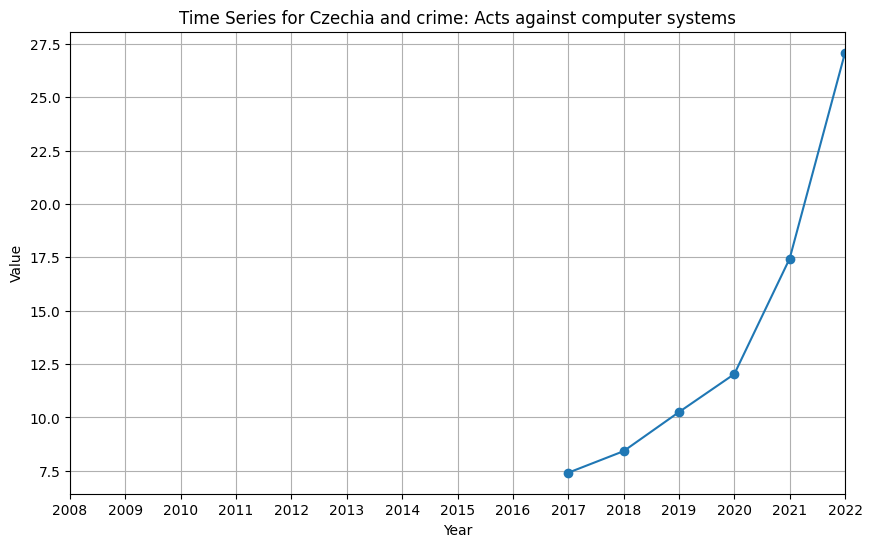

In [21]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['year'], filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

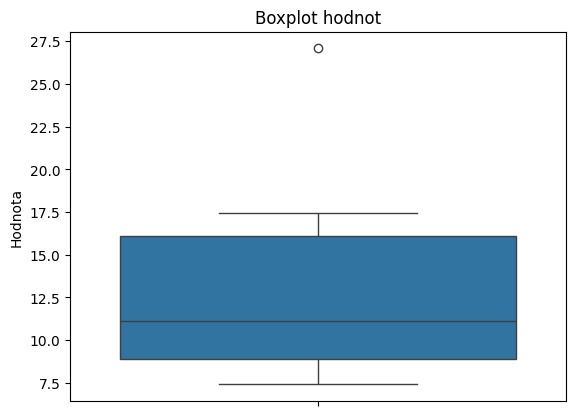

In [22]:




# Předpokládejme, že filtered_data je již definováno jako DataFrame
# Příklad: filtered_data = pd.DataFrame({'value': [1.5, 2.3, 2.5, 3.7, 4.1, ...]})

# Vytvoření boxplotu pro 'value'
# plt.figure(figsize=(10, 6))
sns.boxplot(y='value', data=filtered_data)

# Přidání názvů a popisků
plt.title('Boxplot hodnot')
plt.ylabel('Hodnota')

# Zobrazení grafu
plt.show()

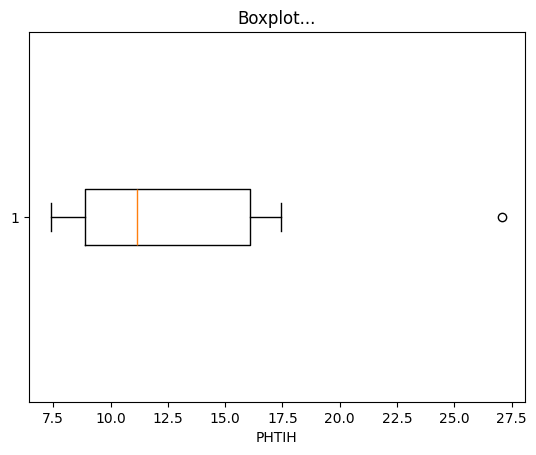

In [23]:
# Create boxplot for Age column
plt.boxplot(filtered_data['value'].dropna(), vert=False, showfliers=True)
plt.xlabel('PHTIH')
plt.title('Boxplot...')

# Show plot
plt.show()

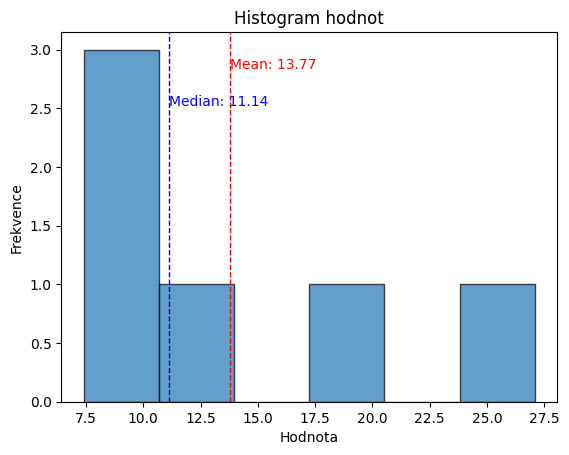

In [24]:
mean_value = round(filtered_data['value'].mean(), 2)
median_value = filtered_data['value'].median()

# Vytvoření histogramu pro 'value'
# plt.figure(figsize=(10, 6))
# sns.histplot(filtered_data['value'], bins=6, kde=True)
plt.hist(filtered_data['value'], bins=6, edgecolor='black', alpha=0.7)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')

# Mean line
plt.axvline(mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(mean_value, plt.ylim()[1]*0.9, f'Mean: {mean_value:.2f}', color = 'red')

# Median line
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=1)
plt.text(median_value, plt.ylim()[1]*0.8, f'Median: {median_value:.2f}', color='blue')



# Zobrazení grafu
plt.show()